## 1. Import libraries

In [1]:
import sys
sys.path.append('../')

%matplotlib inline
from collections import defaultdict
from typing import List
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import MaxNLocator
from statistics import mean
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer

## 2. Auxiliary functions

### 2.1. Reduce state space

In [2]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [3]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

### 2.2. Reward policy

In [4]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

### 2.3. Print results

In [5]:
def print_result(i, scores, total_reward, score):
#     if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

### 2.4. Renderizes a episode

In [12]:
def runGame(env, agent, mask, reduce_state, reduce=True):
    
    actions = []
    score = 0
    total_reward = 0
    
    state = env.reset()
    if reduce:
        state = reduce_state(state)[mask].data.tobytes()  # Select useful bytes
    else:
        state = state[mask].data.tobytes()
        
    action = agent.act(state)
    actions.append(action)
    
    game_over = False
    render  = True
    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)
        
        if reward == 1:
            score+=1
        total_reward+=reward
        
        if reduce:
            state = reduce_state(ob)[mask].data.tobytes()
        else:
            state = ob[mask].data.tobytes()
            
        action = agent.act(state)
        actions.append(action)
    
    return score, total_reward, actions

## 3. Analysis

### 3.1. Load Models

In [ ]:
model_exp01 = serializer.Experiment.load_experiment('models/exp01_model_ql_approximator_6000_2020_12_24_13_21_56.dill')
model_exp02 = serializer.Experiment.load_experiment('models/exp02_model_r3_ql_approximator_6000_2020_12_25_12_00_15.dill')
model_exp03 = serializer.Experiment.load_experiment('models/exp03_model_mean_ql_approximator_6000_2020_12_25_12_53_42.dill')
model_exp04 = serializer.Experiment.load_experiment('models/exp04_model_no_reduce_ql_approximator_6000_2020_12_26_00_25_50.dill')
model_exp05 = serializer.Experiment.load_experiment('models/exp05_model_abs_ql_approximator_6000_2020_12_26_00_53_19.dill')
model_exp08 = serializer.Experiment.load_experiment('models/exp08_model_baseline_ql_approximator_6000_2020_12_26_10_07_09.dill')
model_exp09 = serializer.Experiment.load_experiment('models/exp09_model_all_ram_abs_neg_ql_approximator_6000_2020_12_26_10_02_43.dill')
model_exp10 = serializer.Experiment.load_experiment('models/exp10_model_abs_neg_div3_ql_approximator_6000_2020_12_26_10_16_00.dill')
model_exp11 = serializer.Experiment.load_experiment('models/exp11_model_r50_approximator_6000_2020_12_26_22_27_33.dill')
model_exp12 = serializer.Experiment.load_experiment('models/exp12_model_r100_approximator_6000_2020_12_26_23_04_24.dill')

### 3.1. Experiment 01

In [13]:
model_exp01 = serializer.Experiment.load_experiment('models/exp01_model_ql_approximator_6000_2020_12_24_13_21_56.dill')

In [14]:
mean_score_exp01 = np.sum(model_exp01.scores)/len(model_exp01.scores)
mean_reward_exp01 = np.sum(model_exp01.total_rewards)/len(model_exp01.total_rewards)
mean_weights_exp01 = np.sum(model_exp01.agent.W)/len(model_exp01.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp01, mean_reward_exp01, mean_weights_exp01))

Mean score: 22.6185, Mean reward: 1056.3754666666655, Mean weights: 5.836610180907157


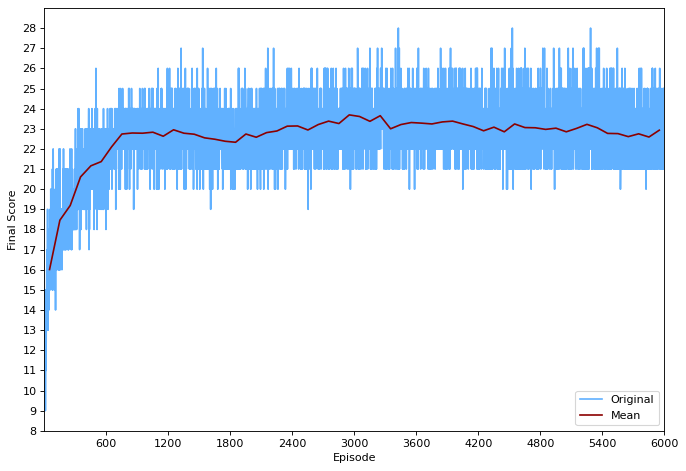

In [15]:
aux_plots.plot_scores_mean(model_exp01.scores)

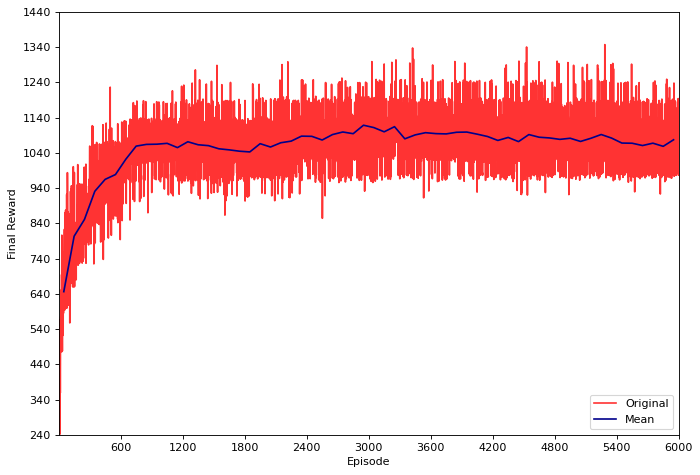

In [16]:
aux_plots.plot_rewards_mean(model_exp01.total_rewards)

In [17]:
setattr(model_exp01.agent, 'feat_type', 'all')
print(model_exp01.agent.feat_type)

all


In [18]:
env, initial_state = environment.get_env()
model_exp01.agent.trainScaler(env, RAM_mask)

score_exp01, reward_exp01, actions_exp01 = runGame(env,model_exp01.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp01, reward_exp01, np.unique(actions_exp01, return_counts=True)))

### 3.2. Experiment 02

In [28]:
model_exp02 = serializer.Experiment.load_experiment('models/exp02_model_r3_ql_approximator_6000_2020_12_25_12_00_15.dill')

In [ ]:
mean_score_exp02 = np.sum(model_exp02.scores)/len(model_exp02.scores)
mean_reward_exp02 = np.sum(model_exp02.total_rewards)/len(model_exp02.total_rewards)
mean_weights_exp02 = np.sum(model_exp02.agent.W)/len(model_exp02.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp02, mean_reward_exp02, mean_weights_exp02))